# SCC0251 - Reconhecimento de objeto por template
Reconhecer um determinado objeto dado uma imagem template e uma imagem em que será feita a análise e destacar o objeto localizado. Os inputs serão as duas imagens e o output será a imagem com o objeto alvo destacado.

Inicialmente vamos começar gerando nossas próprias imagens de input para ir aumentando a dificuldade gradualmente, tendo como objetivo final, a fim de teste, achar a solução do jogo "onde está Wally?" dado o cenário e o Wally (podendo ser de outro cenário).



In [1]:

import numpy as np
import cv2 as cv
import imageio

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from scipy.signal import correlate2d
from scipy.signal import fftconvolve

## Imagens utilizadas


Text(0.5, 1.0, 'Birds template')

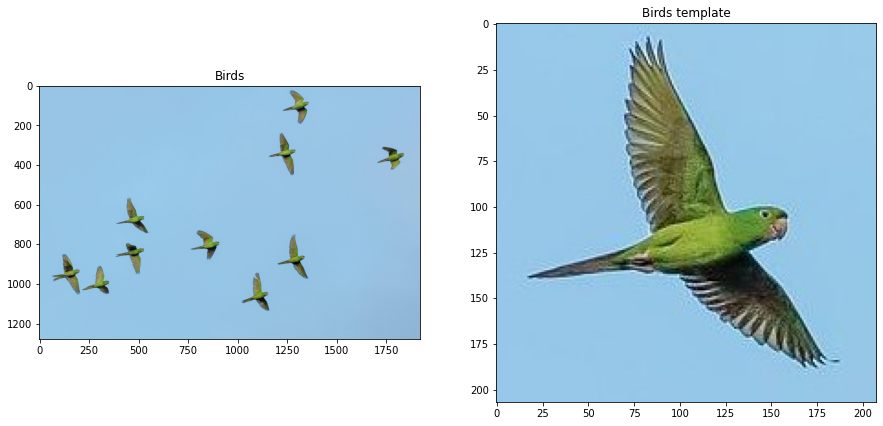

In [2]:
img_birds = imageio.imread('images/birds.jpg')
img_bird = imageio.imread('images/bird.jpg')
img_dices = imageio.imread('images/dices.jpg')
img_dice = imageio.imread('images/dice.jpg')
img_mounts = imageio.imread('images/mounts.png')
img_mount = imageio.imread('images/mount.png')
img_donuts = imageio.imread('images/donuts.png')
img_donut = imageio.imread('images/donut.png')

imgs = [[img_birds, img_bird], [img_dices,img_dice], [img_mounts, img_mount], [img_donuts, img_donut]]
imgs = np.array(imgs, dtype=object)

plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(imgs[0,0]); plt.title("Birds")
plt.subplot(122); plt.imshow(imgs[0,1]); plt.title("Birds template")

## Template Matching

Aqui vamos implementar uma solução baseada na técnica template matching usando um coeficiente de correlação (calculado usando cross-correlation normalizado entre -1 e 1) para achar o objeto desejado e destacá-lo na imagem final.

### Pré processamento necessário

Primeiramente vamos tratar a imagem para garantir que o input será como o previsto nas funções que implementamos e por isso estamos realizando a conversão de RGB para grayscale.

In [3]:
def normalize_minmax(f, factor):
    f_min = np.min(f)
    f_max = np.max(f)
    f = (f - f_min)/(f_max-f_min)
    return (f*factor)

def img_rgb_to_gray(img):
    M, N, Z = img.shape
    img_g = np.zeros((M,N))
    
    img_g = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114
    img_g = normalize_minmax(img_g, 255)
    
    return img_g

Text(0.5, 1.0, 'Template')

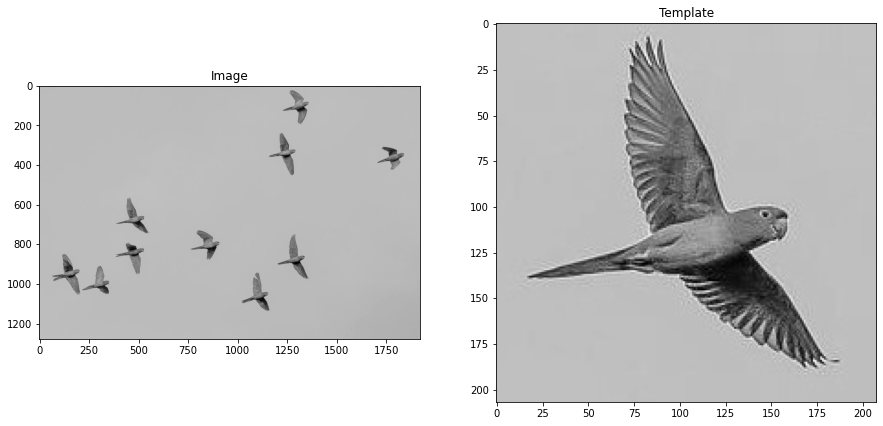

In [4]:
img = img_rgb_to_gray(imgs[0,0])
template = img_rgb_to_gray(imgs[0,1])

plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap="gray"); plt.title("Image")
plt.subplot(122); plt.imshow(template, cmap="gray"); plt.title("Template")